In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

In [36]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

# Data preparation

- Check if the missing values are presented in the features.
- If there are missing values:
     - For caterogiral features, replace them with 'NA'
     - For numerical features, replace with with 0.0

- Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [37]:
for col in df.columns:
    if df[col].isnull().any():
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('NA')
        else:
            df[col] = df[col].fillna(0.0)

In [38]:
X = df.drop(columns=['converted'])
y = df['converted']

# First split into train (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)

# Then split temp into val (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

In [5]:
X_train.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score
340,organic_search,education,3,69033.0,self_employed,north_america,1,0.43
596,organic_search,education,3,0.0,student,middle_east,0,0.52
457,events,education,1,68118.0,student,north_america,7,0.87
175,social_media,finance,0,65044.0,self_employed,africa,5,0.53
549,paid_ads,NA,5,48327.0,employed,north_america,0,0.89


# Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
- If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- lead_score
- number_of_courses_viewed
- interaction_count
- annual_income

In [7]:
num_cols = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

results = []

for col in num_cols:
    # ensure numeric and drop NA in pairwise fashion
    scores = pd.to_numeric(X_train[col], errors='coerce')
    mask = scores.notnull() & pd.Series(y_train).notnull()
    s = scores[mask]
    y = pd.Series(y_train)[mask].astype(int)

    if len(s) == 0:
        print(f"{col}: no valid values in training set (skipping)")
        continue

    auc = roc_auc_score(y, s)
    auc_adjusted = auc
    used_scores = s

    # if AUC < 0.5, invert the scores and recompute
    if auc < 0.5:
        s_inv = -s
        auc_inv = roc_auc_score(y, s_inv)
        auc_adjusted = auc_inv
        used_scores = s_inv
        note = " (inverted)"
    else:
        note = ""

    results.append((col, auc_adjusted, note))

# sort by AUC descending
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

for col, auc_val, note in results_sorted:
    print(f"{col}: {round(auc_val, 3)}{note}")

number_of_courses_viewed: 0.765
interaction_count: 0.727
lead_score: 0.611
annual_income: 0.545


# Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

- LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

In [13]:
# Ensure target arrays are numeric (0/1)
y_train_arr = np.array(y_train).astype(int)
y_val_arr = np.array(y_val).astype(int)

# Create DictVectorizer (support different sklearn versions)
try:
    dv = DictVectorizer(sparse=False)
except TypeError:
    dv = DictVectorizer(sparse_output=False)

# Vectorize training and validation feature data
X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')
X_train_vect = dv.fit_transform(X_train_dict)
X_val_vect = dv.transform(X_val_dict)

# Train logistic regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_vect, y_train_arr)

# Predict probabilities on validation set and compute AUC
y_val_pred_proba = model.predict_proba(X_val_vect)[:, 1]
auc = roc_auc_score(y_val_arr, y_val_pred_proba)
print('AUC (validation) =', round(auc, 3))

AUC (validation) = 0.794


# Question 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

- 0.145
- 0.345
- 0.545
- 0.745

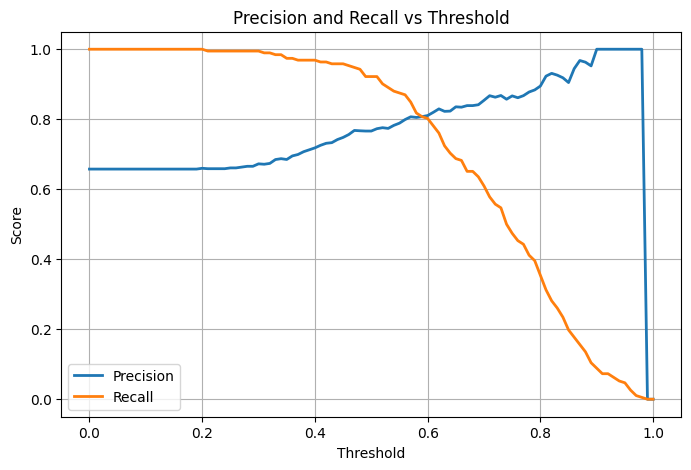

In [22]:
# Evaluate precision & recall over thresholds
thresholds = np.arange(0.0, 1.001, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_t = (y_val_pred_proba >= t).astype(int)
    precisions.append(precision_score(y_val_arr, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_val_arr, y_pred_t, zero_division=0))

precisions = np.array(precisions)
recalls = np.array(recalls)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label='Precision', lw=2)
plt.plot(thresholds, recalls, label='Recall', lw=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

0.14
0.34
0.54
0.74

Max F1 = 0.8485 at thresholds:
 threshold  precision   recall       f1
      0.47   0.767932 0.947917 0.848485


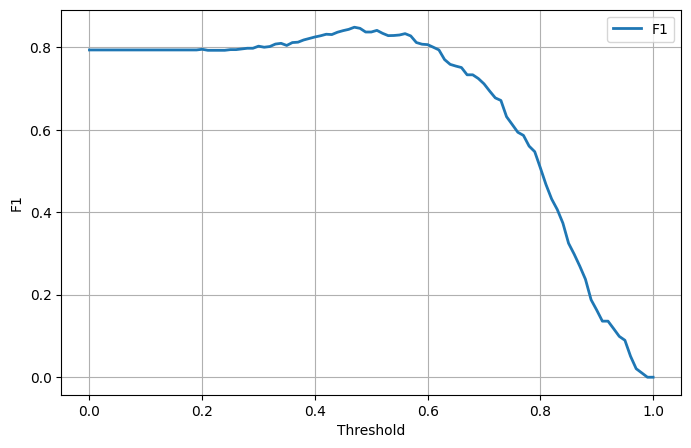

In [27]:
thresholds = np.arange(0.0, 1.001, 0.01)
rows = []

for t in thresholds:
    y_pred_t = (y_val_pred_proba >= t).astype(int)
    p = precision_score(y_val_arr, y_pred_t, zero_division=0)
    r = recall_score(y_val_arr, y_pred_t, zero_division=0)
    f1 = f1_score(y_val_arr, y_pred_t, zero_division=0)
    rows.append((t, p, r, f1))
    
df_thr = pd.DataFrame(rows, columns=['threshold', 'precision', 'recall', 'f1'])
df_thr.head()

# Find max F1 threshold(s)
max_f1 = df_thr['f1'].max()
best = df_thr[df_thr['f1'] == max_f1]
print(f'Max F1 = {max_f1:.4f} at thresholds:')
print(best.to_string(index=False))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, df_thr['f1'], label='F1', lw=2)
plt.xlabel('Threshold')
plt.ylabel('F1')
plt.legend()
plt.grid(True)
plt.show()

# Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36

In [39]:
X.shape

(1462, 8)

In [40]:
y.shape

(1462,)

In [44]:
# Convert to list-of-dicts for DictVectorizer (handles categorical automatically)
dicts = X.to_dict(orient='records')
y_t = y.astype(int).values

# Setup KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

aucs = []
fold = 0
for train_idx, val_idx in kf.split(dicts):
    fold += 1
    # Split raw dicts
    train_dicts = [dicts[i] for i in train_idx]
    val_dicts = [dicts[i] for i in val_idx]
    y_train = y_t[train_idx]
    y_val = y_t[val_idx]

    # Vectorize with DictVectorizer (fit on train only)
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    # Train logistic regression
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    # Predict probabilities and compute AUC
    y_val_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_proba)
    aucs.append(auc)
    print(f'Fold {fold}: AUC = {auc:.5f}')

aucs = np.array(aucs)
print(f'Mean AUC: {aucs.mean():.5f}')
print(f'Std AUC : {aucs.std():.5f}')

Fold 1: AUC = 0.81722
Fold 2: AUC = 0.77928
Fold 3: AUC = 0.83093
Fold 4: AUC = 0.86760
Fold 5: AUC = 0.80934
Mean AUC: 0.82087
Std AUC : 0.02885


# Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [45]:
y.shape

(1462,)

In [48]:
len(dicts)

1462

In [49]:
# Parameters
Cs = [1e-6, 0.001, 1]
kf = KFold(n_splits=5, shuffle=True, random_state=1)

results = {}

for C in Cs:
    aucs = []
    for train_idx, val_idx in kf.split(dicts):
        # Prepare train/val dicts and labels
        train_dicts = [dicts[i] for i in train_idx]
        val_dicts = [dicts[i] for i in val_idx]
        y_train = y_t[train_idx]
        y_val = y_t[val_idx]

        # Vectorize
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)
        X_val = dv.transform(val_dicts)

        # Train and evaluate
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        y_val_proba = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_proba)
        aucs.append(auc)

    aucs = np.array(aucs)
    mean_auc = aucs.mean()
    std_auc = aucs.std()
    results[C] = (mean_auc, std_auc)
    print(f'C={C}: mean AUC={mean_auc:.3f}, std AUC={std_auc:.3f}')

C=1e-06: mean AUC=0.549, std AUC=0.030
C=0.001: mean AUC=0.862, std AUC=0.024
C=1: mean AUC=0.821, std AUC=0.029
